In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import math
#import numdifftools as nd
import pandas as pd
#import pymc3 as pm

from tqdm import tqdm
from sklearn import preprocessing
from numpy.linalg import multi_dot
import scipy
import scipy.stats as ss
from scipy.stats import invgamma
from scipy.special import gamma
from scipy.special import digamma
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import levy_stable
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
import sklearn.mixture

import logging
import warnings
from functools import partial

In [2]:
## Generate actual data
def toad(alpha,
         gamma,
         p0,
         n_toads=66,
         n_days=63,
         batch_size=1,
         random_state=None):
    """Sample the movement of Fowler's toad species.
    Models foraging steps using a levy_stable distribution where individuals
    either return to a previous site or establish a new one.
    References
    ----------
    Marchand, P., Boenke, M., and Green, D. M. (2017).
    A stochastic movement model reproduces patterns of site fidelity and long-
    distance dispersal in a population of fowlers toads (anaxyrus fowleri).
    Ecological Modelling,360:63–69.
    Parameters
    ----------
    alpha : float or array_like with batch_size entries
        step length distribution stability parameter
    gamma : float or array_like with batch_size entries
        step lentgh distribution scale parameter
    p0 : float or array_like with batch_size entries
        probability of returning to a previous refuge site
    n_toads : int, optional
        number of toads
    n_days : int, optional
        number of days
    batch_size : int, optional
    random_state : RandomState, optional
    Returns
    -------
    np.ndarray in shape (n_days x n_toads x batch_size)
    """
    X = np.zeros((n_days, n_toads, batch_size))
    random_state = random_state or np.random
    step_gen = ss.levy_stable
    step_gen.random_state = random_state

    for i in range(1, n_days):
        ret = random_state.uniform(0, 1, (n_toads, batch_size)) < np.squeeze(p0)
        non_ret = np.invert(ret)

        delta_x = step_gen.rvs(alpha, beta=0, scale=gamma, size=(n_toads, batch_size))
        X[i, non_ret] = X[i-1, non_ret] + delta_x[non_ret]

        ind_refuge = random_state.choice(i, size=(n_toads, batch_size))
        X[i, ret] = X[ind_refuge[ret], ret]

    return X


def compute_summaries(X, lag, p=np.linspace(0, 1, 11), thd=10):
    """Compute summaries for toad model.
    For displacements over lag...
        Log of the differences in the p quantiles
        The number of absolute displacements less than thd
        Median of the absolute displacements greater than thd
    Parameters
    ----------
    X : np.array of shape (ndays x ntoads x batch_size)
        observed matrix of toad displacements
    lag : list of ints, optional
        the number of days behind to compute displacement with
    p : np.array, optional
        quantiles used in summary statistic calculation (default 0, 0.1, ... 1)
    thd : float
        toads are considered returned when absolute displacement does not exceed thd (default 10m)
    Returns
    -------
    np.ndarray in shape (batch_size x len(p) + 1)
    """
    disp = obs_mat_to_deltax(X, lag)  # num disp at lag x batch size
    abs_disp = np.abs(disp)
    # returned toads
    ret = abs_disp < thd
    num_ret = np.sum(ret, axis=0)
    # non-returned toads
    abs_disp[ret] = np.nan  # ignore returned toads
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', r'All-NaN slice encountered')
        abs_noret_median = np.nanmedian(abs_disp, axis=0)
        abs_noret_quantiles = np.nanquantile(abs_disp, p, axis=0)
    diff = np.diff(abs_noret_quantiles, axis=0)
    logdiff = np.log(np.maximum(diff, np.exp(-20)))  # substitute zeros with a small positive
    # combine
    ssx = np.vstack((num_ret, abs_noret_median, logdiff))
    ssx = np.nan_to_num(ssx, nan=np.inf)  # nans are when all toads returned
    return np.transpose(ssx)


def obs_mat_to_deltax(X, lag):
    """Convert an observation matrix to a vector of displacements.
    Parameters
    ----------
    X : np.array (n_days x n_toads x batch_size)
        observed matrix of toad displacements
    lag : int
        the number of days behind to compute displacement with
    Returns
    -------
    np.ndarray in shape (n_toads * (n_days - lag) x batch_size)
    """
    batch_size = np.atleast_3d(X).shape[-1]
    return (X[lag:] - X[:-lag]).reshape(-1, batch_size)

In [3]:
true_theta = np.array([1.7, 35.0, 0.6])

In [4]:
actual_data = toad(true_theta[0], true_theta[1], true_theta[2])
actual_data

array([[[   0.        ],
        [   0.        ],
        [   0.        ],
        ...,
        [   0.        ],
        [   0.        ],
        [   0.        ]],

       [[   0.        ],
        [   0.        ],
        [   0.        ],
        ...,
        [ -70.45088802],
        [   1.657245  ],
        [   0.        ]],

       [[  14.80714878],
        [   0.57803704],
        [   0.        ],
        ...,
        [ -70.45088802],
        [-147.8978239 ],
        [ -35.30552663]],

       ...,

       [[ 102.78674401],
        [ -64.41220839],
        [  61.54266854],
        ...,
        [ -55.27840095],
        [-147.8978239 ],
        [ 109.43756247]],

       [[ -17.20182946],
        [ -48.95665149],
        [   0.        ],
        ...,
        [ -79.1833569 ],
        [-224.9815947 ],
        [-188.39615937]],

       [[   4.26330908],
        [  22.76198927],
        [ -18.67689413],
        ...,
        [ -74.86850736],
        [-147.8978239 ],
        [-194.40827957]]

In [5]:
lags = [1, 2, 4, 8]
num_coeffs = 3
num_datasets = 200
n_samples = 200

In [6]:
def compute_summaries_stacked(X, lags):
    S1 = compute_summaries(X, lags[0])
    S2 = compute_summaries(X, lags[1])
    S4 = compute_summaries(X, lags[2])
    S8 = compute_summaries(X, lags[3])
    return np.hstack((S1, S2, S4, S8))

In [7]:
actual_summary_statistics = compute_summaries_stacked(actual_data, lags)[0]
actual_summary_statistics

array([1023.        ,   49.75448736,    1.8304839 ,    1.92257596,
          2.09899033,    2.00254572,    2.40659047,    2.40186802,
          2.88436116,    3.18933236,    3.96139545,    7.06086359,
        908.        ,   63.35873292,    2.19092169,    2.25926323,
          2.25744657,    2.54206966,    2.5314917 ,    2.79247379,
          3.01078205,    3.44611756,    4.11995034,    7.10770861,
        774.        ,   65.66647836,    2.13293682,    2.29921207,
          2.43869563,    2.54804756,    2.55333645,    2.96983758,
          3.16538865,    3.51703812,    4.24604094,    7.07625485,
        674.        ,   65.09138271,    2.1904726 ,    2.30873235,
          2.38908198,    2.50740786,    2.55616598,    2.96771358,
          3.14329216,    3.45298089,    4.23804853,    7.1299602 ])

In [8]:
def summary_statistics(theta, n_samples, n_datasets):
    datasets = toad(theta[0], theta[1], theta[2],batch_size=n_datasets)
    n_summary_statistics = np.array([compute_summaries_stacked(datasets[:,:,i], lags)[0] for i in range(n_datasets)])
    sample_mean = np.mean(n_summary_statistics, axis = 0)
    sample_variance = np.cov(np.array(n_summary_statistics).T)
    return sample_mean, sample_variance

In [9]:
def prior(theta): 
    log_prior = np.sum(np.log(np.exp(theta) / (1 + np.exp(theta))**2))
    return log_prior

def unbiased_log_likelihood(theta):
    ss = summary_statistics(theta, n_samples, num_datasets)
    sample_mean = ss[0]
    sample_variance = ss[1]
    diff_mean_s = actual_summary_statistics - sample_mean
    part1 = diff_mean_s.T @ np.linalg.inv(sample_variance) @ diff_mean_s
    # u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - (self.num_datasets - self.num_coeffs - 2) / (2 * (self.num_datasets-1)) * part1
    u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - part1
    return u_est_log_likelihood

In [10]:
Sigma_0 = np.array([[0.0723577127261181,0.00810822745180408,-0.00176930774868591],
                    [0.00810822745180408,0.00302637280954942,0.000267860261642377],
                    [-0.00176930774868591,0.000267860261642377,0.00409310032764696]])
Sigma_0_inv = scipy.linalg.inv(Sigma_0)
l_0 = scipy.linalg.sqrtm(Sigma_0_inv)
l_0

array([[ 3.94992238, -2.12969451,  0.47239626],
       [-2.12969451, 21.85908684, -1.45228054],
       [ 0.47239626, -1.45228054, 15.84326737]])

In [11]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_datasets = 200 # number of datasets
        self.num_coeffs = 3 # number of coeffs
        self.lambda_dim = self.num_coeffs + int((self.num_coeffs * (self.num_coeffs + 1)) / 2)
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def log_q(self, theta, mu, l):
        log_q = multivariate_normal.logpdf(theta, mean = mu, cov= np.linalg.inv(l @ l.T))
        return log_q

    def gradient_log_q(self, theta, mu, l): #indep theta
        gradient_log_q_mu = np.matmul(np.matmul(l, l.T), (theta - mu))
        diag_inv_l = np.zeros((num_coeffs, num_coeffs))
        np.fill_diagonal(diag_inv_l, np.diag(np.linalg.inv(l)))
        gradient_log_q_l = (diag_inv_l - np.reshape(theta - mu, (num_coeffs,1)) @ np.reshape(theta - mu, (1,num_coeffs)) @ l).T[np.triu_indices(num_coeffs)] #use * because matmul gives scalar 
        gradient_log_q = np.array([gradient_log_q_mu, gradient_log_q_l], dtype=object)
        return gradient_log_q

    def control_variates(self, Flat_grad_log_q, Flat_grad_lb):
        c = []
        stacked_gradient_lb = np.stack(Flat_grad_lb)
        stacked_gradient_log_q = np.stack(Flat_grad_log_q)
        for i in range(self.lambda_dim):
            sample_cov = np.cov((stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i]))
            c_i = sample_cov[0, 1] / sample_cov[1, 1]
            c.append(c_i)
        c_mu = np.array(c[0:self.num_coeffs])
        c_vech_l = np.array(c[self.num_coeffs:])
        return np.array([c_mu, c_vech_l], dtype = object)

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        # mu_0 = np.array([np.log((true_theta[0] - 1)/(2 - true_theta[0])),np.log((true_theta[1] - 0)/(100 - true_theta[1])),np.log((true_theta[2] - 0)/(0.9 - true_theta[2]))])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        mu_0 = np.array([0] * self.num_coeffs)
        # l_0 = np.array([[ 3.94992238, -2.12969451,  0.47239626],
        #                 [-2.12969451, 21.85908684, -1.45228054],
        #                 [ 0.47239626, -1.45228054, 15.84326737]])
        l_0 = np.tril(np.identity(self.num_coeffs) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = np.linalg.inv(Sigma_0_inv)
        l_0_inv = np.linalg.inv(l_0)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[np.triu_indices(self.num_coeffs)]

        lambda_0 = np.array([mu_0, vech_l0], dtype = object)
        lambda_q = lambda_0
        # Initilize best lambda
        lambda_best = lambda_0
        # List of Lambda
        Lambda = [lambda_0]
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []
        for t in tqdm(range(stop)):
            if t == 0:        
                # Draw samples of theta from  variational q
                # List of gradients
                Gradient_lb_init = []
                lb_0 = []
                theta_0_samples = multivariate_normal.rvs(mean = mu_0, cov = Sigma_0, size = self.samples)
                for s in tqdm(range(self.samples)):
                    # True params have been reparam into epsilon
                    theta_tilde_0 = theta_0_samples[s]
                    alpha_0 = (2 * np.exp(theta_tilde_0[0]) + 1) / (1 + np.exp(theta_tilde_0[0]))
                    beta_0 = (100 * np.exp(theta_tilde_0[1]) + 0) / (1 + np.exp(theta_tilde_0[1]))
                    gamma_0 = (0.9 * np.exp(theta_tilde_0[2]) + 0) / (1 + np.exp(theta_tilde_0[2]))
                    theta_0 = np.array([alpha_0, beta_0, gamma_0])
                    
                    # Find gradient of LB
                    h_lambda_init = prior(theta_tilde_0) + unbiased_log_likelihood(theta_0) - self.log_q(theta_tilde_0, mu_0, l_0)
                    gradient_lb_init = self.gradient_log_q(theta_tilde_0, mu_0, l_0) * (h_lambda_init)
                    Gradient_lb_init.append(gradient_lb_init)
                    # Calculate control variates
                    flattened_gradient_log_q = np.concatenate((self.gradient_log_q(theta_tilde_0, mu_0, l_0)[0], self.gradient_log_q(theta_tilde_0, mu_0, l_0)[1]), axis = None)
                    Flattened_gradient_log_q.append(flattened_gradient_log_q)
                    flattened_gradient_lb = np.concatenate((gradient_lb_init[0], gradient_lb_init[1]), axis = None)
                    Flattened_gradient_lb.append(flattened_gradient_lb)
                    # Calculate lower bound
                    lb_0.append(h_lambda_init)
                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_init = np.mean(Gradient_lb_init, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(self.g_init, axis = None)) > self.l_threshold:
                    self.g_init = self.l_threshold * self.g_init / np.linalg.norm(np.concatenate(self.g_init, axis = None))
                self.v_init = self.g_init ** 2
                # Calculate lower bound
                LB_all.append(np.mean(lb_0))
                print('LB', (np.mean(lb_0)))
                lambda_q = lambda_0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q[0]

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q[1])
                l_q = np.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q[i:self.num_coeffs,i] = vech_lq[:self.num_coeffs - i]
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  np.linalg.inv(Sigma_q_inv)
                l_q_inv =  np.linalg.inv(l_q)
                # List of gradients
                Gradient_lb = []
                lb_t = []
                theta_q_samples = multivariate_normal.rvs(mean = mu_q, cov = Sigma_q, size = self.samples)
                for s in range(self.samples):
                    theta_tilde_q = theta_q_samples[s]
                    # Calculate theta from mu, l (lambda)
                    alpha_q = (2 * np.exp(theta_tilde_q[0]) + 1) / (1 + np.exp(theta_tilde_q[0]))
                    beta_q = (100 * np.exp(theta_tilde_q[1]) + 0) / (1 + np.exp(theta_tilde_q[1]))
                    gamma_q = (0.9 * np.exp(theta_tilde_q[2]) + 0) / (1 + np.exp(theta_tilde_q[2]))
                    theta_q = np.array([alpha_q, beta_q, gamma_q])
                    
                    # Find gradient of LB
                    h_lambda = prior(theta_tilde_q) + unbiased_log_likelihood(theta_q) - self.log_q(theta_tilde_q, mu_q, l_q)
                    # Find gradient of LB
                    gradient_lb = self.gradient_log_q(theta_tilde_q, mu_q, l_q) * (h_lambda - c)

                    Gradient_lb.append(gradient_lb)
                    # Calculate control variates
                    Flattened_gradient_log_q[s] = np.concatenate((self.gradient_log_q(theta_tilde_q, mu_q, l_q)[0], self.gradient_log_q(theta_tilde_q, mu_q, l_q)[1]), axis = None)
                    Flattened_gradient_lb[s] = np.concatenate((gradient_lb[0], gradient_lb[1]), axis = None)
                    # Calc lower bound estimate
                    lb_t.append(h_lambda)
                # Update control variates
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Calc gradient of h
                g_t = np.mean(Gradient_lb, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(g_t, axis = None)) > self.l_threshold:
                    g_t = self.l_threshold * g_t / np.linalg.norm(np.concatenate(g_t, axis = None))
                v_t = g_t ** 2

                #---- Update lambda
                self.g_init = self.adaptive_lr_1 * self.g_init + (1 - self.adaptive_lr_1) * g_t
                self.v_init = self.adaptive_lr_2 * self.v_init + (1 - self.adaptive_lr_2) * v_t
                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q = lambda_q + update_t * self.g_init / (self.v_init ** 0.5)
                Lambda.append(lambda_q)
                # Calculate lower bound
                LB_all.append(np.mean(lb_t))

                if t < self.t_w:
                    print('LB', np.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = np.mean(LB_all[t - self.t_w + 1 : t])
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= max(LB_Smoothed):
                        patience = 0
                        lambda_best = lambda_q
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best

In [12]:
# Set hyperparameters
stop = 5000
vb = GVB(400, actual_summary_statistics, 0.005, 2500, 100, 0.9, 0.9, 100, 50)
LB_estimate, smoothed_LB_estimate, best_lambda = vb.vb_posterior(stop)

  0%|          | 1/5000 [09:12<767:19:38, 552.59s/it]

LB -21032.27272543693


  0%|          | 2/5000 [20:40<877:51:58, 632.32s/it]

LB -20996.494712649517


  0%|          | 3/5000 [32:02<908:49:08, 654.74s/it]

LB -21064.538918825227


  0%|          | 4/5000 [46:04<1011:35:20, 728.93s/it]

LB -20821.834046316875


  0%|          | 5/5000 [1:01:13<1101:09:53, 793.63s/it]

LB -19358.861997947293


  0%|          | 6/5000 [1:16:08<1148:54:19, 828.21s/it]

LB -19509.765379628618


  0%|          | 7/5000 [1:29:52<1146:34:47, 826.69s/it]

LB -19047.671663536206


  0%|          | 8/5000 [1:44:24<1166:39:38, 841.34s/it]

LB -18340.0265042708


  0%|          | 9/5000 [1:58:28<1167:34:37, 842.17s/it]

LB -17676.78167049942


  0%|          | 10/5000 [2:13:01<1180:28:11, 851.64s/it]

LB -17701.115673157066


  0%|          | 11/5000 [2:24:53<1120:56:07, 808.85s/it]

LB -17179.757193414192


  0%|          | 12/5000 [2:36:00<1061:01:18, 765.77s/it]

LB -16927.155768833112


  0%|          | 13/5000 [2:47:10<1020:35:49, 736.75s/it]

LB -16231.333771342246


  0%|          | 14/5000 [2:58:20<992:16:23, 716.44s/it] 

LB -15958.546777075604


  0%|          | 15/5000 [3:10:08<988:41:19, 714.00s/it]

LB -15499.639660670795


  0%|          | 16/5000 [3:22:19<995:28:15, 719.04s/it]

LB -15265.09338027712


  0%|          | 17/5000 [3:34:03<989:12:56, 714.67s/it]

LB -14879.010303356261


  0%|          | 18/5000 [3:45:44<983:19:19, 710.55s/it]

LB -14968.491610293137


  0%|          | 19/5000 [3:57:22<977:52:25, 706.75s/it]

LB -13646.455430521555


  0%|          | 20/5000 [4:09:02<974:56:30, 704.78s/it]

LB -13728.135975104306


  0%|          | 21/5000 [4:20:27<966:16:55, 698.66s/it]

LB -13489.847754984521


  0%|          | 22/5000 [4:32:41<980:48:48, 709.31s/it]

LB -13354.066498087528


  0%|          | 23/5000 [4:44:58<992:12:04, 717.69s/it]

LB -13072.04510982886


  0%|          | 24/5000 [4:57:00<993:43:27, 718.93s/it]

LB -12522.607631962672


  0%|          | 25/5000 [5:09:01<994:14:36, 719.45s/it]

LB -11968.380191981008


  1%|          | 26/5000 [5:20:48<988:52:06, 715.71s/it]

LB -11362.327595565812


  1%|          | 27/5000 [5:32:35<985:04:15, 713.10s/it]

LB -11319.321446282787


  1%|          | 28/5000 [5:44:33<987:00:43, 714.65s/it]

LB -10874.864472197041


  1%|          | 29/5000 [5:56:22<984:27:52, 712.95s/it]

LB -10942.15541992765


  1%|          | 30/5000 [6:08:11<982:35:21, 711.73s/it]

LB -10390.878395598105


  1%|          | 31/5000 [6:20:03<982:49:28, 712.05s/it]

LB -10184.035497075443


  1%|          | 32/5000 [6:31:52<981:08:30, 710.97s/it]

LB -9651.467028458132


  1%|          | 33/5000 [6:43:45<981:38:01, 711.47s/it]

LB -9896.26041688323


  1%|          | 34/5000 [6:55:40<983:04:02, 712.65s/it]

LB -9895.349923037402


  1%|          | 35/5000 [7:07:54<991:35:33, 718.98s/it]

LB -8848.663364061606


  1%|          | 36/5000 [7:19:55<992:22:30, 719.69s/it]

LB -8830.150491991853


  1%|          | 37/5000 [7:31:48<989:32:56, 717.79s/it]

LB -8401.617652053972


  1%|          | 38/5000 [7:43:37<985:40:23, 715.12s/it]

LB -7971.189638475001


  1%|          | 39/5000 [7:55:20<980:30:12, 711.51s/it]

LB -8176.824115329326


  1%|          | 40/5000 [8:06:58<974:30:10, 707.30s/it]

LB -7707.034446108804


  1%|          | 41/5000 [8:18:39<971:52:53, 705.54s/it]

LB -7762.700976310099


  1%|          | 42/5000 [8:30:21<970:03:02, 704.35s/it]

LB -7063.151524977605


  1%|          | 43/5000 [8:42:07<970:42:48, 704.98s/it]

LB -7235.107183425187


  1%|          | 44/5000 [8:53:49<969:12:53, 704.03s/it]

LB -7224.954269970847


  1%|          | 45/5000 [9:05:26<966:10:17, 701.96s/it]

LB -6891.488001141337


  1%|          | 46/5000 [9:17:11<967:09:27, 702.82s/it]

LB -6464.306739496349


  1%|          | 47/5000 [9:29:00<969:35:25, 704.73s/it]

LB -6038.00578717615


  1%|          | 48/5000 [9:41:02<976:24:22, 709.83s/it]

LB -5996.223854261432


  1%|          | 49/5000 [9:52:56<977:54:50, 711.07s/it]

LB -5974.7921898063805


  1%|          | 50/5000 [10:04:46<977:24:33, 710.84s/it]

LB -5836.412291908895


  1%|          | 51/5000 [10:16:39<978:09:31, 711.53s/it]

LB -5225.624528812083


  1%|          | 52/5000 [10:28:44<983:27:02, 715.53s/it]

LB -5350.219450475544


  1%|          | 53/5000 [10:40:40<983:16:38, 715.54s/it]

LB -4873.261909460931


  1%|          | 54/5000 [10:52:39<984:35:40, 716.65s/it]

LB -4761.9017423748


  1%|          | 55/5000 [11:04:49<989:40:25, 720.49s/it]

LB -4869.814544553814


  1%|          | 56/5000 [11:16:37<984:30:03, 716.87s/it]

LB -4647.678657149323


  1%|          | 57/5000 [11:28:33<984:05:51, 716.72s/it]

LB -4477.621559652563


  1%|          | 58/5000 [11:40:47<991:02:29, 721.92s/it]

LB -4296.569001539624


  1%|          | 59/5000 [11:52:40<986:54:00, 719.05s/it]

LB -4063.240998283374


  1%|          | 60/5000 [12:05:29<1007:18:39, 734.07s/it]

LB -3962.9269640168723


  1%|          | 61/5000 [12:18:23<1023:46:43, 746.22s/it]

LB -3750.376777742619


  1%|          | 62/5000 [12:30:49<1023:20:54, 746.06s/it]

LB -3654.7474743013317


  1%|▏         | 63/5000 [12:42:51<1013:23:16, 738.95s/it]

LB -3437.016594061956


  1%|▏         | 64/5000 [12:54:56<1007:03:12, 734.48s/it]

LB -3503.1987026452857


  1%|▏         | 65/5000 [13:07:00<1002:52:00, 731.57s/it]

LB -3127.7949823758736


  1%|▏         | 66/5000 [13:19:12<1002:48:08, 731.68s/it]

LB -2935.3815141360365


  1%|▏         | 67/5000 [13:31:26<1003:27:24, 732.30s/it]

LB -2977.7956627312706


  1%|▏         | 68/5000 [13:44:48<1032:03:21, 753.33s/it]

LB -2808.434983267229


  1%|▏         | 69/5000 [14:00:04<1098:33:00, 802.02s/it]

LB -2911.0429528062436


  1%|▏         | 70/5000 [14:15:27<1148:08:05, 838.39s/it]

LB -2687.283399928785


  1%|▏         | 71/5000 [14:31:15<1192:39:38, 871.09s/it]

LB -2470.6553866192376


  1%|▏         | 72/5000 [14:43:52<1145:33:47, 836.86s/it]

LB -2461.262005464332


  1%|▏         | 73/5000 [14:56:01<1101:10:29, 804.59s/it]

LB -2382.9402610145685


  1%|▏         | 74/5000 [15:08:09<1069:28:50, 781.59s/it]

LB -2360.545544081031


  2%|▏         | 75/5000 [15:20:31<1052:51:55, 769.61s/it]

LB -2233.431971330993


  2%|▏         | 76/5000 [15:32:58<1043:28:09, 762.89s/it]

LB -2035.1737475231996


  2%|▏         | 77/5000 [15:46:12<1056:18:35, 772.44s/it]

LB -2027.1934673664787


  2%|▏         | 78/5000 [15:59:18<1061:29:57, 776.39s/it]

LB -1871.3331698307218


  2%|▏         | 79/5000 [16:12:01<1055:47:50, 772.38s/it]

LB -1809.8229068999226


  2%|▏         | 80/5000 [16:24:43<1051:16:43, 769.23s/it]

LB -1898.2023261578747


  2%|▏         | 81/5000 [16:37:25<1048:12:47, 767.14s/it]

LB -1752.9151035233697


  2%|▏         | 82/5000 [16:50:21<1051:21:59, 769.61s/it]

LB -1752.0754079585167


  2%|▏         | 83/5000 [17:02:59<1046:44:42, 766.38s/it]

LB -1580.8331269342848


  2%|▏         | 84/5000 [17:16:09<1055:52:58, 773.23s/it]

LB -1581.8656550767157


  2%|▏         | 85/5000 [17:28:59<1054:25:35, 772.32s/it]

LB -1437.1395142527276


  2%|▏         | 86/5000 [17:41:58<1057:06:41, 774.44s/it]

LB -1395.5488824401214


  2%|▏         | 87/5000 [17:55:02<1060:33:41, 777.13s/it]

LB -1344.669852337505


  2%|▏         | 88/5000 [18:07:40<1052:40:24, 771.50s/it]

LB -1316.4420566111385


  2%|▏         | 89/5000 [18:20:26<1050:11:27, 769.84s/it]

LB -1213.1028035495517


  2%|▏         | 90/5000 [18:33:04<1045:09:56, 766.31s/it]

LB -1264.9302817116652


  2%|▏         | 91/5000 [18:45:46<1043:21:44, 765.15s/it]

LB -1123.5315258320034


  2%|▏         | 92/5000 [18:58:39<1046:20:28, 767.49s/it]

LB -1118.7477873184948


  2%|▏         | 93/5000 [19:11:44<1052:57:55, 772.50s/it]

LB -1068.9629189633697


  2%|▏         | 94/5000 [19:24:44<1055:56:01, 774.84s/it]

LB -1005.3060033792194


  2%|▏         | 95/5000 [19:37:27<1050:46:50, 771.22s/it]

LB -988.5489948497136


  2%|▏         | 96/5000 [19:50:04<1044:46:24, 766.96s/it]

LB -858.6596205752322


  2%|▏         | 97/5000 [20:02:41<1040:42:29, 764.13s/it]

LB -896.1710340687672


  2%|▏         | 98/5000 [20:15:21<1038:38:37, 762.77s/it]

LB -837.2698590173707


  2%|▏         | 99/5000 [20:28:06<1039:12:38, 763.35s/it]

LB -766.3941856117832


  2%|▏         | 100/5000 [20:40:47<1038:02:16, 762.64s/it]

LB -831.7171987632028


  2%|▏         | 101/5000 [20:53:33<1039:34:17, 763.92s/it]

LB Smoothed -7355.093589348111


  2%|▏         | 102/5000 [21:06:12<1037:11:34, 762.33s/it]

LB Smoothed -7151.241380761068


  2%|▏         | 103/5000 [21:18:53<1036:36:19, 762.05s/it]

LB Smoothed -6946.061168604555


  2%|▏         | 104/5000 [21:31:35<1036:20:55, 762.02s/it]

LB Smoothed -6743.171051459415


  2%|▏         | 105/5000 [21:44:28<1040:14:41, 765.04s/it]

LB Smoothed -6554.270887315475


  2%|▏         | 106/5000 [21:57:08<1038:22:16, 763.82s/it]

LB Smoothed -6363.810006191355


  2%|▏         | 107/5000 [22:09:46<1035:42:41, 762.02s/it]

LB Smoothed -6177.971224864831


  2%|▏         | 108/5000 [22:22:27<1034:46:09, 761.48s/it]

LB Smoothed -5998.516767186276


  2%|▏         | 109/5000 [22:35:10<1035:33:05, 762.21s/it]

LB Smoothed -5824.981004702901


  2%|▏         | 110/5000 [22:47:55<1036:10:11, 762.82s/it]

LB Smoothed -5651.791494088347


  2%|▏         | 111/5000 [23:00:36<1035:31:56, 762.51s/it]

LB Smoothed -5483.884904114735


  2%|▏         | 112/5000 [23:13:18<1034:46:50, 762.11s/it]

LB Smoothed -5318.281476840452


  2%|▏         | 113/5000 [23:26:08<1037:43:45, 764.44s/it]

LB Smoothed -5159.124176470436


  2%|▏         | 114/5000 [23:38:55<1038:55:00, 765.47s/it]

LB Smoothed -5002.532012134252


  2%|▏         | 115/5000 [23:51:51<1042:38:16, 768.37s/it]

LB Smoothed -4850.395118231757


  2%|▏         | 116/5000 [24:04:43<1044:04:53, 769.59s/it]

LB Smoothed -4700.203449764545


  2%|▏         | 117/5000 [24:17:20<1038:55:47, 765.95s/it]

LB Smoothed -4554.109611139289


  2%|▏         | 118/5000 [24:30:18<1043:19:31, 769.35s/it]

LB Smoothed -4407.1700747960185


  2%|▏         | 119/5000 [24:43:16<1046:54:31, 772.15s/it]

LB Smoothed -4273.444519707605


  2%|▏         | 120/5000 [24:56:10<1047:07:31, 772.47s/it]

LB Smoothed -4138.722030216044


  2%|▏         | 121/5000 [25:08:25<1031:40:35, 761.23s/it]

LB Smoothed -4005.8373286522956


  2%|▏         | 122/5000 [25:20:10<1008:33:11, 744.32s/it]

LB Smoothed -3874.689278215626


  2%|▏         | 123/5000 [25:31:56<993:07:54, 733.09s/it] 

LB Smoothed -3746.068227180236


  2%|▏         | 124/5000 [25:38:06<845:12:33, 624.03s/it]

LB Smoothed -3622.9017475944993


  2%|▎         | 125/5000 [25:41:51<683:06:08, 504.44s/it]

LB Smoothed -3505.434585011976


  3%|▎         | 126/5000 [25:45:50<574:55:43, 424.65s/it]

LB Smoothed -3393.8964343034368


  3%|▎         | 127/5000 [25:49:24<489:14:08, 361.43s/it]

LB Smoothed -3282.68847746204


  3%|▎         | 128/5000 [25:53:44<448:09:18, 331.15s/it]

LB Smoothed -3175.8129586680784


  3%|▎         | 129/5000 [25:57:37<407:56:11, 301.49s/it]

LB Smoothed -3067.717565059585


  3%|▎         | 130/5000 [26:01:20<376:02:25, 277.98s/it]

LB Smoothed -2965.641345029679


  3%|▎         | 131/5000 [26:06:21<385:30:31, 285.03s/it]

LB Smoothed -2865.544155151102


  3%|▎         | 132/5000 [26:13:22<440:39:45, 325.88s/it]

LB Smoothed -2770.6842001747837


  3%|▎         | 133/5000 [26:20:17<476:44:30, 352.63s/it]

LB Smoothed -2672.951990369735


  3%|▎         | 134/5000 [26:24:49<443:35:50, 328.19s/it]

LB Smoothed -2575.3208912688747


  3%|▎         | 135/5000 [26:28:37<402:57:28, 298.18s/it]

LB Smoothed -2488.1280955310444


  3%|▎         | 136/5000 [26:31:51<360:37:50, 266.91s/it]

LB Smoothed -2401.050645162978


  3%|▎         | 137/5000 [26:37:58<401:18:56, 297.09s/it]

LB Smoothed -2318.1439433150763


  3%|▎         | 138/5000 [26:44:20<435:45:51, 322.66s/it]

LB Smoothed -2239.525552165463


  3%|▎         | 139/5000 [26:50:31<455:05:26, 337.03s/it]

LB Smoothed -2158.8344858003743


  3%|▎         | 140/5000 [26:56:22<460:30:49, 341.12s/it]

LB Smoothed -2082.672422903689


  3%|▎         | 141/5000 [27:02:13<464:42:55, 344.30s/it]

LB Smoothed -2005.8749511514318


  3%|▎         | 142/5000 [27:07:52<462:17:02, 342.57s/it]

LB Smoothed -1936.028465909879


  3%|▎         | 143/5000 [27:13:43<465:28:35, 345.01s/it]

LB Smoothed -1864.5044406715006


  3%|▎         | 144/5000 [27:19:51<474:46:24, 351.97s/it]

LB Smoothed -1792.7719384547613


  3%|▎         | 145/5000 [27:26:24<491:10:15, 364.21s/it]

LB Smoothed -1724.673350690899


  3%|▎         | 146/5000 [27:32:56<502:39:49, 372.80s/it]

LB Smoothed -1660.6312970728436


  3%|▎         | 147/5000 [27:39:24<508:30:21, 377.21s/it]

LB Smoothed -1600.8326175310135


  3%|▎         | 148/5000 [27:46:04<517:43:30, 384.13s/it]

LB Smoothed -1541.5111277091592


  3%|▎         | 149/5000 [27:52:38<521:26:31, 386.97s/it]

LB Smoothed -1482.2901945826716


  3%|▎         | 150/5000 [27:58:49<514:49:03, 382.13s/it]

LB Smoothed -1424.3645992262313


  3%|▎         | 151/5000 [28:04:42<503:09:56, 373.56s/it]

LB Smoothed -1372.675961588515


  3%|▎         | 152/5000 [28:10:40<496:33:35, 368.73s/it]

LB Smoothed -1320.0378209797375


  3%|▎         | 153/5000 [28:16:31<489:15:08, 363.38s/it]

LB Smoothed -1271.9782595399436


  3%|▎         | 154/5000 [28:22:22<484:15:33, 359.75s/it]

LB Smoothed -1224.962418335945


  3%|▎         | 155/5000 [28:28:02<476:23:46, 353.98s/it]

LB Smoothed -1176.9022568568669


  3%|▎         | 156/5000 [28:33:45<471:47:51, 350.63s/it]

LB Smoothed -1130.9011395160019


  3%|▎         | 157/5000 [28:39:33<470:22:24, 349.65s/it]

LB Smoothed -1086.8358421609355


  3%|▎         | 158/5000 [28:44:45<455:21:26, 338.56s/it]

LB Smoothed -1044.5590226336421


  3%|▎         | 159/5000 [28:49:12<426:13:28, 316.96s/it]

LB Smoothed -1004.5945632544707


  3%|▎         | 160/5000 [28:53:17<397:05:10, 295.35s/it]

LB Smoothed -965.7028397395418


  3%|▎         | 161/5000 [28:57:25<377:50:17, 281.09s/it]

LB Smoothed -929.0050177433064


  3%|▎         | 162/5000 [29:01:28<362:39:37, 269.86s/it]

LB Smoothed -893.3245683522933


  3%|▎         | 163/5000 [29:05:33<352:20:13, 262.23s/it]

LB Smoothed -859.6246087673356


  3%|▎         | 164/5000 [29:10:04<356:02:01, 265.04s/it]

LB Smoothed -825.2460943133999


  3%|▎         | 165/5000 [29:14:14<349:44:02, 260.40s/it]

LB Smoothed -794.658625040506


  3%|▎         | 166/5000 [29:18:34<349:40:58, 260.42s/it]

LB Smoothed -766.1063895896725


  3%|▎         | 167/5000 [29:22:43<344:45:58, 256.81s/it]

LB Smoothed -737.0022752294449


  3%|▎         | 168/5000 [29:26:44<338:30:28, 252.20s/it]

LB Smoothed -709.4627473401974


  3%|▎         | 169/5000 [29:30:57<338:44:39, 252.43s/it]

LB Smoothed -680.9927445895186


  3%|▎         | 170/5000 [29:35:11<339:05:51, 252.74s/it]

LB Smoothed -654.8624994715419


  3%|▎         | 171/5000 [29:39:24<339:16:37, 252.93s/it]

LB Smoothed -630.8199569225807


  3%|▎         | 172/5000 [29:44:00<348:27:46, 259.83s/it]

LB Smoothed -606.804463442661


  3%|▎         | 173/5000 [29:48:27<351:11:12, 261.92s/it]

LB Smoothed -583.4586052956394


  3%|▎         | 174/5000 [29:52:33<344:43:40, 257.15s/it]

LB Smoothed -560.545758516124


  4%|▎         | 175/5000 [29:56:46<343:14:17, 256.09s/it]

LB Smoothed -538.8361231185752


  4%|▎         | 176/5000 [30:01:30<354:25:10, 264.49s/it]

LB Smoothed -518.9621155500929


  4%|▎         | 177/5000 [30:05:57<354:59:13, 264.97s/it]

LB Smoothed -499.20965015146714


  4%|▎         | 178/5000 [30:10:00<346:28:11, 258.67s/it]

LB Smoothed -480.8022020724881


  4%|▎         | 179/5000 [30:14:31<351:09:52, 262.23s/it]

LB Smoothed -463.08035528734996


  4%|▎         | 180/5000 [30:19:03<355:08:25, 265.25s/it]

LB Smoothed -444.4570452979017


  4%|▎         | 181/5000 [30:23:14<349:02:58, 260.75s/it]

LB Smoothed -427.41158295213273


  4%|▎         | 182/5000 [30:27:14<340:57:13, 254.76s/it]

LB Smoothed -410.26949437891096


  4%|▎         | 183/5000 [30:32:56<375:35:23, 280.70s/it]

LB Smoothed -394.843911781048


  4%|▎         | 184/5000 [30:39:28<420:27:58, 314.30s/it]

LB Smoothed -379.4051240108328


  4%|▎         | 185/5000 [30:46:27<462:06:44, 345.50s/it]

LB Smoothed -365.42889966308996


  4%|▎         | 186/5000 [30:53:19<488:58:48, 365.67s/it]

LB Smoothed -351.8208678849586


  4%|▎         | 187/5000 [31:00:14<508:37:20, 380.44s/it]

LB Smoothed -338.69120925608775


  4%|▍         | 188/5000 [31:07:13<523:47:46, 391.87s/it]

LB Smoothed -325.93925736120207


  4%|▍         | 189/5000 [31:12:47<500:39:09, 374.63s/it]

LB Smoothed -314.1506334915917


  4%|▍         | 190/5000 [31:16:44<445:08:41, 333.16s/it]

LB Smoothed -301.8364289515701


  4%|▍         | 191/5000 [31:20:40<406:21:13, 304.19s/it]

LB Smoothed -290.93612934074224


  4%|▍         | 192/5000 [31:24:17<371:13:08, 277.95s/it]

LB Smoothed -280.0330920482689


  4%|▍         | 193/5000 [31:27:56<347:28:43, 260.23s/it]

LB Smoothed -269.6219689318785


  4%|▍         | 194/5000 [31:31:41<333:14:14, 249.62s/it]

LB Smoothed -259.9276987042813


  4%|▍         | 195/5000 [31:35:25<323:09:02, 242.11s/it]

LB Smoothed -250.25468635648724


  4%|▍         | 196/5000 [31:39:09<315:43:01, 236.59s/it]

LB Smoothed -241.77153635597995


  4%|▍         | 197/5000 [31:42:50<309:38:26, 232.09s/it]

LB Smoothed -233.02022319490078


  4%|▍         | 198/5000 [31:46:29<304:07:14, 228.00s/it]

LB Smoothed -224.77700148786695


  4%|▍         | 199/5000 [31:50:07<300:08:20, 225.06s/it]

LB Smoothed -217.2412747557954


  4%|▍         | 200/5000 [31:54:00<303:02:00, 227.28s/it]

LB Smoothed -209.1708522734639


  4%|▍         | 201/5000 [31:57:38<299:36:33, 224.75s/it]

LB Smoothed -201.09538653300365


  4%|▍         | 202/5000 [32:01:26<300:28:24, 225.45s/it]

LB Smoothed -193.61775596416408


  4%|▍         | 203/5000 [32:04:53<293:11:59, 220.04s/it]

LB Smoothed -186.32987826603534


  4%|▍         | 204/5000 [32:08:34<293:24:25, 220.24s/it]

LB Smoothed -179.8496021063709


  4%|▍         | 205/5000 [32:11:53<284:51:44, 213.87s/it]

LB Smoothed -173.3231691629937


  4%|▍         | 206/5000 [32:15:41<290:37:44, 218.24s/it]

LB Smoothed -166.95631714554298


  4%|▍         | 207/5000 [32:19:12<287:28:40, 215.92s/it]

LB Smoothed -161.2951524693302


  4%|▍         | 208/5000 [32:23:00<292:27:53, 219.71s/it]

LB Smoothed -156.38363477057024


  4%|▍         | 209/5000 [32:26:58<299:36:13, 225.12s/it]

LB Smoothed -150.8587727331097


  4%|▍         | 210/5000 [32:31:09<309:43:34, 232.78s/it]

LB Smoothed -145.26622892410685


  4%|▍         | 211/5000 [32:35:07<311:50:09, 234.41s/it]

LB Smoothed -139.95349830287026


  4%|▍         | 212/5000 [32:38:46<305:46:40, 229.91s/it]

LB Smoothed -135.23229262080903


  4%|▍         | 213/5000 [32:42:47<310:04:03, 233.18s/it]

LB Smoothed -130.6735036670872


  4%|▍         | 214/5000 [32:46:19<301:31:30, 226.81s/it]

LB Smoothed -126.30720565648399


  4%|▍         | 215/5000 [32:49:45<293:03:41, 220.49s/it]

LB Smoothed -122.34052350154978


  4%|▍         | 216/5000 [32:53:21<291:26:50, 219.32s/it]

LB Smoothed -118.12005669181148


  4%|▍         | 217/5000 [32:56:43<284:27:59, 214.11s/it]

LB Smoothed -113.86887795284407


  4%|▍         | 218/5000 [33:00:23<286:33:37, 215.73s/it]

LB Smoothed -109.70343209775545


  4%|▍         | 219/5000 [33:04:07<290:02:13, 218.39s/it]

LB Smoothed -105.76351247842008


  4%|▍         | 220/5000 [33:07:44<289:11:15, 217.80s/it]

LB Smoothed -102.45742310212725


  4%|▍         | 221/5000 [33:11:12<285:22:04, 214.97s/it]

LB Smoothed -98.63542851505316


  4%|▍         | 222/5000 [33:14:51<286:46:42, 216.07s/it]

LB Smoothed -95.2457797589909


  4%|▍         | 223/5000 [33:18:25<285:52:11, 215.43s/it]

LB Smoothed -91.95345294432572


  4%|▍         | 224/5000 [33:22:12<290:38:56, 219.08s/it]

LB Smoothed -88.44294432362062


  4%|▍         | 225/5000 [33:25:39<285:48:19, 215.48s/it]

LB Smoothed -85.17240877588081


  5%|▍         | 226/5000 [33:29:08<282:53:30, 213.32s/it]

LB Smoothed -81.9856455291552


  5%|▍         | 227/5000 [33:32:40<282:18:53, 212.93s/it]

LB Smoothed -78.98682342765255


  5%|▍         | 228/5000 [33:36:09<280:54:25, 211.92s/it]

LB Smoothed -76.4921839429441


  5%|▍         | 229/5000 [33:39:40<280:28:05, 211.63s/it]

LB Smoothed -73.57206566333817


  5%|▍         | 230/5000 [33:43:12<280:35:14, 211.76s/it]

LB Smoothed -70.73047680973846


  5%|▍         | 231/5000 [33:46:46<281:17:54, 212.35s/it]

LB Smoothed -68.06820566955025


  5%|▍         | 232/5000 [33:50:41<290:25:19, 219.28s/it]

LB Smoothed -65.75968894087393


  5%|▍         | 233/5000 [33:54:46<300:27:44, 226.91s/it]

LB Smoothed -63.42704649894605


  5%|▍         | 234/5000 [33:58:55<309:16:56, 233.62s/it]

LB Smoothed -61.132086603649604


  5%|▍         | 235/5000 [34:02:43<306:58:00, 231.92s/it]

LB Smoothed -58.965303140457856


  5%|▍         | 236/5000 [34:06:19<300:37:32, 227.17s/it]

LB Smoothed -56.935535340308476


  5%|▍         | 237/5000 [34:09:57<296:34:34, 224.16s/it]

LB Smoothed -54.99633470623541


  5%|▍         | 238/5000 [34:13:26<290:43:00, 219.78s/it]

LB Smoothed -53.03948737137812


  5%|▍         | 239/5000 [34:17:08<291:25:43, 220.36s/it]

LB Smoothed -51.29611885823092


  5%|▍         | 240/5000 [34:20:45<290:12:04, 219.48s/it]

LB Smoothed -49.62161871562698


  5%|▍         | 241/5000 [34:24:07<283:00:22, 214.08s/it]

LB Smoothed -48.06479011486166


  5%|▍         | 242/5000 [34:27:56<288:47:21, 218.50s/it]

LB Smoothed -46.4383094929146


  5%|▍         | 243/5000 [34:31:36<289:35:30, 219.16s/it]

LB Smoothed -45.14340779668132


  5%|▍         | 244/5000 [34:35:10<287:27:03, 217.58s/it]

LB Smoothed -43.570630054003956


  5%|▍         | 245/5000 [34:38:40<284:28:36, 215.38s/it]

LB Smoothed -42.27170459892964


  5%|▍         | 246/5000 [34:42:12<282:54:52, 214.24s/it]

LB Smoothed -41.04612282395541


  5%|▍         | 247/5000 [34:45:38<279:40:57, 211.84s/it]

LB Smoothed -39.76380347776062


  5%|▍         | 248/5000 [34:49:14<281:02:21, 212.91s/it]

LB Smoothed -38.664217411440774


  5%|▍         | 249/5000 [34:53:01<286:30:45, 217.10s/it]

LB Smoothed -37.56673203471891


  5%|▌         | 250/5000 [34:56:37<286:15:09, 216.95s/it]

LB Smoothed -36.426701488713114


  5%|▌         | 251/5000 [35:00:01<280:59:46, 213.01s/it]

LB Smoothed -34.95305917193244


  5%|▌         | 252/5000 [35:03:35<281:32:03, 213.46s/it]

LB Smoothed -33.75716454026206


  5%|▌         | 253/5000 [35:07:09<281:21:16, 213.37s/it]

LB Smoothed -32.67597273462579


  5%|▌         | 254/5000 [35:10:56<286:56:21, 217.65s/it]

LB Smoothed -31.47244439662653


  5%|▌         | 255/5000 [35:14:31<285:39:39, 216.73s/it]

LB Smoothed -30.512897798081767


  5%|▌         | 256/5000 [35:18:16<288:56:52, 219.27s/it]

LB Smoothed -29.370428691487525


  5%|▌         | 257/5000 [35:21:49<286:15:28, 217.27s/it]

LB Smoothed -28.21101838531996


  5%|▌         | 258/5000 [35:25:16<282:25:27, 214.41s/it]

LB Smoothed -27.121429341122116


  5%|▌         | 259/5000 [35:28:30<274:09:13, 208.17s/it]

LB Smoothed -25.99063307001857


  5%|▌         | 260/5000 [35:32:04<276:30:55, 210.01s/it]

LB Smoothed -24.810847589458273


  5%|▌         | 261/5000 [35:35:27<273:36:47, 207.85s/it]

LB Smoothed -23.570024114117945


  5%|▌         | 262/5000 [35:39:04<277:06:59, 210.56s/it]

LB Smoothed -22.531112388485447


  5%|▌         | 263/5000 [35:42:43<280:22:28, 213.08s/it]

LB Smoothed -21.50701665143053


  5%|▌         | 264/5000 [35:46:21<282:22:58, 214.65s/it]

LB Smoothed -20.506119549201042


  5%|▌         | 265/5000 [35:49:53<281:13:35, 213.82s/it]

LB Smoothed -19.37335952969552


  5%|▌         | 266/5000 [35:53:25<280:24:00, 213.23s/it]

LB Smoothed -18.381114114973958


  5%|▌         | 267/5000 [35:56:57<279:46:16, 212.80s/it]

LB Smoothed -17.59174203888501


  5%|▌         | 268/5000 [36:00:47<286:29:10, 217.95s/it]

LB Smoothed -16.659990371411013


  5%|▌         | 269/5000 [36:04:09<280:10:45, 213.20s/it]

LB Smoothed -15.626639421793808


  5%|▌         | 270/5000 [36:07:37<278:07:55, 211.69s/it]

LB Smoothed -14.74287608848133


  5%|▌         | 271/5000 [36:11:20<282:39:19, 215.17s/it]

LB Smoothed -13.925690322354113


  5%|▌         | 272/5000 [36:14:44<278:00:34, 211.68s/it]

LB Smoothed -13.234183874863348


  5%|▌         | 273/5000 [36:18:08<274:59:48, 209.43s/it]

LB Smoothed -12.335870808364085


  5%|▌         | 274/5000 [36:21:34<273:32:01, 208.36s/it]

LB Smoothed -11.552406286614175


  6%|▌         | 275/5000 [36:25:11<277:01:01, 211.06s/it]

LB Smoothed -10.820094095593287


  6%|▌         | 276/5000 [36:28:47<278:40:41, 212.37s/it]

LB Smoothed -10.115503273969203


  6%|▌         | 277/5000 [36:32:20<278:55:03, 212.60s/it]

LB Smoothed -9.697732980386442


  6%|▌         | 278/5000 [36:35:57<280:39:01, 213.96s/it]

LB Smoothed -9.149780959950627


  6%|▌         | 279/5000 [36:39:18<275:39:18, 210.20s/it]

LB Smoothed -8.590502999780508


  6%|▌         | 280/5000 [36:43:04<281:50:01, 214.96s/it]

LB Smoothed -7.993930079959611


  6%|▌         | 281/5000 [36:46:52<286:43:44, 218.74s/it]

LB Smoothed -7.442159554593409


  6%|▌         | 282/5000 [36:49:45<268:47:18, 205.10s/it]

LB Smoothed -6.876050164226846


  6%|▌         | 283/5000 [36:52:37<255:36:52, 195.08s/it]

LB Smoothed -6.294415587065017


  6%|▌         | 284/5000 [36:55:28<246:01:48, 187.81s/it]

LB Smoothed -5.713779001012837


  6%|▌         | 285/5000 [36:58:19<239:36:49, 182.95s/it]

LB Smoothed -5.203083128106741


  6%|▌         | 286/5000 [37:01:11<234:54:11, 179.39s/it]

LB Smoothed -4.724487938362096


  6%|▌         | 287/5000 [37:04:02<231:40:43, 176.97s/it]

LB Smoothed -4.145980945979929


  6%|▌         | 288/5000 [37:06:57<230:43:23, 176.27s/it]

LB Smoothed -3.644371663046551


  6%|▌         | 289/5000 [37:09:48<228:51:25, 174.89s/it]

LB Smoothed -3.1963232918358484


  6%|▌         | 290/5000 [37:12:40<227:31:17, 173.90s/it]

LB Smoothed -2.7207162316930127


  6%|▌         | 291/5000 [37:15:31<226:25:43, 173.10s/it]

LB Smoothed -2.265258188594407


  6%|▌         | 292/5000 [37:18:44<234:08:01, 179.03s/it]

LB Smoothed -1.8559596025836995


  6%|▌         | 293/5000 [37:22:23<249:50:32, 191.08s/it]

LB Smoothed -1.3852423722744327


  6%|▌         | 294/5000 [37:25:46<254:26:54, 194.65s/it]

LB Smoothed -1.018690742145905


  6%|▌         | 295/5000 [37:30:01<277:59:08, 212.70s/it]

LB Smoothed -0.8262044527853206


  6%|▌         | 296/5000 [37:33:39<279:58:27, 214.27s/it]

LB Smoothed -0.5411152990402109


  6%|▌         | 297/5000 [37:37:31<286:46:16, 219.51s/it]

LB Smoothed -0.25429167118384466


  6%|▌         | 298/5000 [37:40:58<282:07:37, 216.01s/it]

LB Smoothed -0.03245152327264665


  6%|▌         | 299/5000 [37:43:44<262:09:24, 200.76s/it]

LB Smoothed 0.34212676944260756


  6%|▌         | 300/5000 [37:46:56<258:52:07, 198.28s/it]

LB Smoothed 0.5895827089119106


  6%|▌         | 301/5000 [37:50:23<262:12:21, 200.88s/it]

LB Smoothed 0.7540565215999874


  6%|▌         | 302/5000 [37:54:29<279:53:22, 214.47s/it]

LB Smoothed 0.9643913472994178


  6%|▌         | 303/5000 [37:58:20<286:18:48, 219.44s/it]

LB Smoothed 1.1964103346117352


  6%|▌         | 304/5000 [38:01:51<282:55:09, 216.89s/it]

LB Smoothed 1.324092537212523


  6%|▌         | 305/5000 [38:05:52<292:20:10, 224.16s/it]

LB Smoothed 1.6059066584253276


  6%|▌         | 306/5000 [38:09:15<283:54:37, 217.74s/it]

LB Smoothed 1.8453062189468736


  6%|▌         | 307/5000 [38:12:43<279:53:50, 214.71s/it]

LB Smoothed 2.0123137993842373


  6%|▌         | 308/5000 [38:16:18<280:09:05, 214.95s/it]

LB Smoothed 2.1837840637345023


  6%|▌         | 309/5000 [38:20:10<286:39:29, 219.99s/it]

LB Smoothed 2.3620326367189457


  6%|▌         | 310/5000 [38:23:22<275:29:59, 211.47s/it]

LB Smoothed 2.5210824815938504


  6%|▌         | 311/5000 [38:27:05<280:11:15, 215.12s/it]

LB Smoothed 2.7072071175778856


  6%|▌         | 312/5000 [38:30:21<272:44:21, 209.44s/it]

LB Smoothed 2.8603724901533103


  6%|▋         | 313/5000 [38:33:41<268:53:33, 206.53s/it]

LB Smoothed 3.071609926858079


  6%|▋         | 314/5000 [38:37:24<275:25:09, 211.59s/it]

LB Smoothed 3.2354612271112764


  6%|▋         | 315/5000 [38:41:16<283:17:19, 217.68s/it]

LB Smoothed 3.351277623722556


  6%|▋         | 316/5000 [38:44:52<282:33:57, 217.17s/it]

LB Smoothed 3.5069167721974353


  6%|▋         | 317/5000 [38:48:23<280:02:34, 215.28s/it]

LB Smoothed 3.5796141449185632


  6%|▋         | 318/5000 [38:52:02<281:09:23, 216.18s/it]

LB Smoothed 3.7227170593472168


  6%|▋         | 319/5000 [38:55:36<280:20:03, 215.60s/it]

LB Smoothed 3.9107610655032095


  6%|▋         | 320/5000 [38:58:46<270:13:48, 207.87s/it]

LB Smoothed 3.983159459585258


  6%|▋         | 321/5000 [39:01:39<256:55:26, 197.68s/it]

LB Smoothed 4.130179492732777


  6%|▋         | 322/5000 [39:04:36<248:40:16, 191.37s/it]

LB Smoothed 4.313610312018561


  6%|▋         | 323/5000 [39:07:23<238:55:46, 183.91s/it]

LB Smoothed 4.373234674637195


  6%|▋         | 324/5000 [39:10:11<232:58:41, 179.37s/it]

LB Smoothed 4.451581956340973


  6%|▋         | 325/5000 [39:13:08<231:49:42, 178.52s/it]

LB Smoothed 4.494473104741533


  7%|▋         | 326/5000 [39:16:27<239:53:33, 184.77s/it]

LB Smoothed 4.602447382703964


  7%|▋         | 327/5000 [39:20:05<252:48:07, 194.75s/it]

LB Smoothed 4.646151011724068


  7%|▋         | 328/5000 [39:23:17<251:43:45, 193.97s/it]

LB Smoothed 4.706548594492642


  7%|▋         | 329/5000 [39:26:31<251:25:31, 193.78s/it]

LB Smoothed 4.741142275261429


  7%|▋         | 330/5000 [39:29:36<248:04:21, 191.23s/it]

LB Smoothed 4.784827071136506


  7%|▋         | 331/5000 [39:33:32<265:14:31, 204.51s/it]

LB Smoothed 4.803149419937097


  7%|▋         | 332/5000 [39:37:13<271:56:30, 209.72s/it]

LB Smoothed 4.908055027468372


  7%|▋         | 333/5000 [39:40:44<272:06:38, 209.90s/it]

LB Smoothed 4.898387261467503


  7%|▋         | 334/5000 [39:44:24<275:58:12, 212.92s/it]

LB Smoothed 4.939421362758371


  7%|▋         | 335/5000 [39:47:36<267:46:07, 206.64s/it]

LB Smoothed 4.948528365967443


  7%|▋         | 336/5000 [39:50:53<264:05:44, 203.85s/it]

LB Smoothed 4.967150623932817


  7%|▋         | 337/5000 [39:54:19<264:53:57, 204.51s/it]

LB Smoothed 5.045442239475284


  7%|▋         | 338/5000 [39:58:27<281:52:07, 217.66s/it]

LB Smoothed 5.078855303075015


  7%|▋         | 339/5000 [40:02:07<282:24:37, 218.12s/it]

LB Smoothed 5.0903871390207405


  7%|▋         | 340/5000 [40:05:07<267:37:37, 206.75s/it]

LB Smoothed 5.115758061613057


  7%|▋         | 341/5000 [40:08:59<277:35:58, 214.50s/it]

LB Smoothed 5.148047653318586


  7%|▋         | 342/5000 [40:13:08<290:47:24, 224.74s/it]

LB Smoothed 5.191691578757711


  7%|▋         | 343/5000 [40:16:30<282:01:21, 218.01s/it]

LB Smoothed 5.228325888845353


  7%|▋         | 344/5000 [40:19:55<276:33:10, 213.83s/it]

LB Smoothed 5.245504176573937


  7%|▋         | 345/5000 [40:24:25<298:25:56, 230.80s/it]

LB Smoothed 5.318346397205743


  7%|▋         | 346/5000 [40:28:14<297:42:19, 230.28s/it]

LB Smoothed 5.348158840239498


  7%|▋         | 347/5000 [40:32:15<301:42:14, 233.43s/it]

LB Smoothed 5.421758587887264


  7%|▋         | 348/5000 [40:35:42<291:39:02, 225.70s/it]

LB Smoothed 5.411009499946805


  7%|▋         | 349/5000 [40:39:05<282:35:45, 218.74s/it]

LB Smoothed 5.392368782735565


  7%|▋         | 350/5000 [40:42:34<278:57:01, 215.96s/it]

LB Smoothed 5.370286709378613


  7%|▋         | 351/5000 [40:46:05<277:00:37, 214.51s/it]

LB Smoothed 5.380081586726858


  7%|▋         | 352/5000 [40:49:30<273:01:05, 211.46s/it]

LB Smoothed 5.380783709094945


  7%|▋         | 353/5000 [40:53:24<281:56:24, 218.42s/it]

LB Smoothed 5.381597228852453


  7%|▋         | 354/5000 [40:57:28<291:36:31, 225.96s/it]

LB Smoothed 5.435239793290786


  7%|▋         | 355/5000 [41:01:44<303:01:52, 234.86s/it]

LB Smoothed 5.517866529053976


  7%|▋         | 356/5000 [41:05:38<302:36:06, 234.57s/it]

LB Smoothed 5.505638618329052


  7%|▋         | 357/5000 [41:09:45<307:26:58, 238.38s/it]

LB Smoothed 5.527828761907659


  7%|▋         | 358/5000 [41:13:30<302:16:45, 234.43s/it]

LB Smoothed 5.594503198097441


  7%|▋         | 359/5000 [41:16:51<289:09:05, 224.29s/it]

LB Smoothed 5.689787938081396


  7%|▋         | 360/5000 [41:20:16<281:49:16, 218.65s/it]

LB Smoothed 5.766610200810345


  7%|▋         | 361/5000 [41:23:31<272:28:00, 211.44s/it]

LB Smoothed 5.759630437610123


  7%|▋         | 362/5000 [41:26:47<266:25:20, 206.80s/it]

LB Smoothed 5.829239083609642


  7%|▋         | 363/5000 [41:30:43<277:40:24, 215.58s/it]

LB Smoothed 5.892434519340232


  7%|▋         | 364/5000 [41:33:55<268:24:13, 208.42s/it]

LB Smoothed 5.907403979953501


  7%|▋         | 365/5000 [41:37:15<265:05:36, 205.90s/it]

LB Smoothed 5.956888124793431


  7%|▋         | 366/5000 [41:40:52<269:28:19, 209.34s/it]

LB Smoothed 6.075101143475616


  7%|▋         | 367/5000 [41:45:36<298:14:25, 231.74s/it]

LB Smoothed 6.105276732331256


  7%|▋         | 368/5000 [41:49:58<309:43:23, 240.72s/it]

LB Smoothed 6.172355389151758


  7%|▋         | 369/5000 [41:54:04<311:53:29, 242.46s/it]

LB Smoothed 6.258735513704911


  7%|▋         | 370/5000 [41:58:16<315:36:48, 245.40s/it]

LB Smoothed 6.345139606781501


  7%|▋         | 371/5000 [42:02:08<310:04:52, 241.15s/it]

LB Smoothed 6.452800037243205


  7%|▋         | 372/5000 [42:05:22<292:03:55, 227.19s/it]

LB Smoothed 6.518006782158934


  7%|▋         | 373/5000 [42:09:20<296:12:17, 230.46s/it]

LB Smoothed 6.665112531513923


  7%|▋         | 374/5000 [42:13:08<295:08:31, 229.68s/it]

LB Smoothed 6.650422905686954


  8%|▊         | 375/5000 [42:16:51<292:29:31, 227.67s/it]

LB Smoothed 6.672770631705582


  8%|▊         | 376/5000 [42:20:38<291:55:36, 227.28s/it]

LB Smoothed 6.8292597819837955


  8%|▊         | 377/5000 [42:24:33<294:53:10, 229.63s/it]

LB Smoothed 6.910257875429924


  8%|▊         | 378/5000 [42:27:56<284:47:46, 221.82s/it]

LB Smoothed 6.983147189294281


  8%|▊         | 379/5000 [42:31:18<276:59:32, 215.79s/it]

LB Smoothed 7.15197523871402


  8%|▊         | 380/5000 [42:34:36<270:03:20, 210.43s/it]

LB Smoothed 7.249199854471316


  8%|▊         | 381/5000 [42:37:57<266:31:46, 207.73s/it]

LB Smoothed 7.270830885026425


  8%|▊         | 382/5000 [42:41:23<265:51:25, 207.25s/it]

LB Smoothed 7.265503700128049


  8%|▊         | 383/5000 [42:44:43<262:47:48, 204.91s/it]

LB Smoothed 7.342908365696319


  8%|▊         | 384/5000 [42:48:19<266:57:56, 208.21s/it]

LB Smoothed 7.409399890400702


  8%|▊         | 385/5000 [42:51:53<269:20:22, 210.10s/it]

LB Smoothed 7.476448177476484


  8%|▊         | 386/5000 [42:55:41<276:04:00, 215.40s/it]

LB Smoothed 7.5417093661397425


  8%|▊         | 387/5000 [42:59:27<279:57:38, 218.48s/it]

LB Smoothed 7.6130708137821985


  8%|▊         | 388/5000 [43:02:59<277:37:23, 216.71s/it]

LB Smoothed 7.727865303534348


  8%|▊         | 389/5000 [43:06:45<281:07:01, 219.48s/it]

LB Smoothed 7.801675115553355


  8%|▊         | 390/5000 [43:09:39<263:39:13, 205.89s/it]

LB Smoothed 7.80532140283553


  8%|▊         | 391/5000 [43:13:07<264:03:31, 206.25s/it]

LB Smoothed 7.8785665396147255


  8%|▊         | 392/5000 [43:16:22<259:46:33, 202.95s/it]

LB Smoothed 7.952586948939524


  8%|▊         | 393/5000 [43:19:23<251:22:23, 196.43s/it]

LB Smoothed 7.9809714543365695


  8%|▊         | 394/5000 [43:23:02<259:56:49, 203.17s/it]

LB Smoothed 8.061858427776865


  8%|▊         | 395/5000 [43:26:41<266:09:10, 208.07s/it]

LB Smoothed 8.140280175965168


  8%|▊         | 396/5000 [43:30:21<270:39:14, 211.63s/it]

LB Smoothed 8.145866507840406


  8%|▊         | 397/5000 [43:34:22<281:51:37, 220.44s/it]

LB Smoothed 8.17413936239876


  8%|▊         | 398/5000 [43:38:08<283:39:27, 221.90s/it]

LB Smoothed 8.159872088682686


  8%|▊         | 399/5000 [43:41:52<284:39:30, 222.73s/it]

LB Smoothed 8.187148825690617


  8%|▊         | 400/5000 [43:45:36<284:48:00, 222.89s/it]

LB Smoothed 8.195179153675081


  8%|▊         | 401/5000 [43:49:16<283:40:42, 222.06s/it]

LB Smoothed 8.158315537413939


  8%|▊         | 402/5000 [43:53:25<293:58:57, 230.17s/it]

LB Smoothed 8.118980527080582


  8%|▊         | 403/5000 [43:57:22<296:34:01, 232.25s/it]

LB Smoothed 8.163205637223728


  8%|▊         | 404/5000 [44:01:12<295:31:31, 231.48s/it]

LB Smoothed 8.152738334201885


  8%|▊         | 405/5000 [44:05:20<301:56:59, 236.57s/it]

LB Smoothed 8.095060497161365


  8%|▊         | 406/5000 [44:09:15<301:18:40, 236.12s/it]

LB Smoothed 8.089084524293664


  8%|▊         | 407/5000 [44:12:39<288:54:45, 226.45s/it]

LB Smoothed 8.04300252392599


  8%|▊         | 408/5000 [44:16:27<289:36:59, 227.05s/it]

LB Smoothed 7.969828801545721


  8%|▊         | 409/5000 [44:20:17<290:35:23, 227.86s/it]

LB Smoothed 7.908901035276982


  8%|▊         | 410/5000 [44:24:20<296:15:52, 232.36s/it]

LB Smoothed 7.780978205979101


  8%|▊         | 411/5000 [44:27:52<288:16:33, 226.15s/it]

LB Smoothed 7.722410620837509


  8%|▊         | 412/5000 [44:31:27<284:02:56, 222.88s/it]

LB Smoothed 7.588905555335376


  8%|▊         | 413/5000 [44:34:55<278:26:07, 218.52s/it]

LB Smoothed 7.521563890160075


  8%|▊         | 414/5000 [44:38:22<273:54:58, 215.02s/it]

LB Smoothed 7.3948445096837165


  8%|▊         | 415/5000 [44:42:48<293:17:43, 230.29s/it]

LB Smoothed 7.251780635524397


  8%|▊         | 416/5000 [44:47:25<311:06:39, 244.33s/it]

LB Smoothed 7.162446341171273


  8%|▊         | 417/5000 [44:52:12<327:13:03, 257.03s/it]

LB Smoothed 7.042781141218888


  8%|▊         | 418/5000 [44:56:39<331:06:15, 260.14s/it]

LB Smoothed 6.937177809146953


  8%|▊         | 419/5000 [45:00:55<329:12:18, 258.71s/it]

LB Smoothed 6.821123104613748


  8%|▊         | 420/5000 [45:05:25<333:33:32, 262.19s/it]

LB Smoothed 6.733148857484747


  8%|▊         | 421/5000 [45:09:51<334:48:18, 263.22s/it]

LB Smoothed 6.609682174984025


  8%|▊         | 422/5000 [45:14:14<334:57:52, 263.41s/it]

LB Smoothed 6.488661651906494


  8%|▊         | 423/5000 [45:18:02<321:10:44, 252.62s/it]

LB Smoothed 6.402052075206498


  8%|▊         | 424/5000 [45:21:50<311:44:38, 245.25s/it]

LB Smoothed 6.316382913039515


  8%|▊         | 425/5000 [45:25:34<303:27:18, 238.78s/it]

LB Smoothed 6.169144027503104


  9%|▊         | 426/5000 [45:29:32<303:10:24, 238.61s/it]

LB Smoothed 6.057532089915498


  9%|▊         | 427/5000 [45:33:15<297:02:29, 233.84s/it]

LB Smoothed 5.952750431788708


  9%|▊         | 428/5000 [45:37:09<297:14:46, 234.05s/it]

LB Smoothed 5.783520839181438


  9%|▊         | 429/5000 [45:40:53<293:25:41, 231.10s/it]

LB Smoothed 5.662615846891456


  9%|▊         | 430/5000 [45:44:38<290:52:49, 229.14s/it]

LB Smoothed 5.511934034250885


  9%|▊         | 431/5000 [45:48:40<295:37:21, 232.93s/it]

LB Smoothed 5.390896824530649


  9%|▊         | 432/5000 [45:52:12<287:47:50, 226.81s/it]

LB Smoothed 5.296198080046582


  9%|▊         | 433/5000 [45:56:05<290:01:08, 228.61s/it]

LB Smoothed 5.189304716125802


  9%|▊         | 434/5000 [45:59:54<290:08:29, 228.76s/it]

LB Smoothed 5.110822329272821


  9%|▊         | 435/5000 [46:03:33<286:25:47, 225.88s/it]

LB Smoothed 5.006682275665912


  9%|▊         | 436/5000 [46:07:14<284:22:58, 224.32s/it]

LB Smoothed 4.857267606255948


  9%|▊         | 437/5000 [46:11:12<289:25:33, 228.34s/it]

LB Smoothed 4.7599676858100874


  9%|▉         | 438/5000 [46:15:05<291:18:44, 229.88s/it]

LB Smoothed 4.701708646437309


  9%|▉         | 439/5000 [46:18:52<289:58:38, 228.88s/it]

LB Smoothed 4.590815645705606


  9%|▉         | 440/5000 [46:22:24<283:45:42, 224.02s/it]

LB Smoothed 4.510436896125395


  9%|▉         | 441/5000 [46:25:55<278:43:31, 220.09s/it]

LB Smoothed 4.438204218597861


  9%|▉         | 442/5000 [46:29:44<281:54:46, 222.66s/it]

LB Smoothed 4.377448068922798


  9%|▉         | 443/5000 [46:33:26<281:35:35, 222.46s/it]

LB Smoothed 4.296124946192755


  9%|▉         | 444/5000 [46:37:14<283:41:31, 224.16s/it]

LB Smoothed 4.148818450680068


  9%|▉         | 445/5000 [46:40:58<283:26:15, 224.01s/it]

LB Smoothed 4.025459531275473


  9%|▉         | 446/5000 [46:44:29<278:35:49, 220.23s/it]

LB Smoothed 3.9804959517711684


  9%|▉         | 447/5000 [46:48:10<278:42:38, 220.37s/it]

LB Smoothed 3.8646315482755873


  9%|▉         | 448/5000 [46:51:42<275:24:52, 217.81s/it]

LB Smoothed 3.767886108754399


  9%|▉         | 449/5000 [46:55:09<271:17:35, 214.60s/it]

LB Smoothed 3.673067065421966


  9%|▉         | 450/5000 [46:58:50<273:53:25, 216.70s/it]

LB Smoothed 3.546057847685501


  9%|▉         | 450/5000 [47:02:31<475:38:53, 376.34s/it]

LB Smoothed 3.4896926360004255
Stop at 450


In [20]:
best_lambda

array([array([ 0.27622615, -0.74745479,  0.61374992]),
       array([10.16813795, -0.10345628,  0.1444975 , 10.12639174, -0.51460499,
              10.27553239])                                                   ],
      dtype=object)

<AxesSubplot: title={'center': 'Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

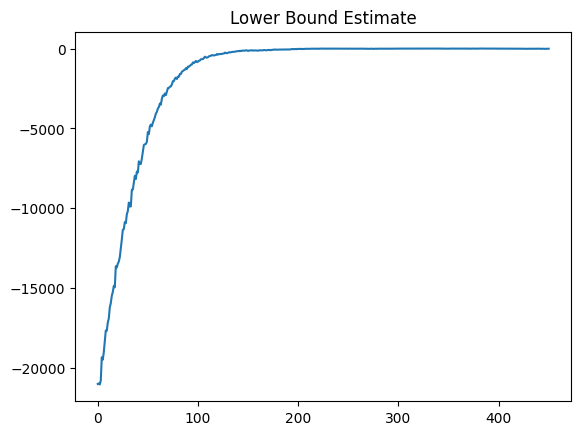

In [21]:
lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<AxesSubplot: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

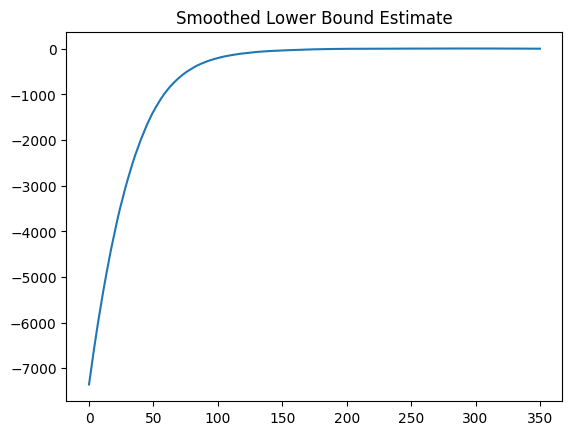

In [22]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [25]:
best_mu = best_lambda[0]
best_vech_l = list(best_lambda[1])
best_l = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l[i:num_coeffs,i] = best_vech_l[:num_coeffs - i]
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  np.linalg.inv(best_Sigma_inv)

best_theta_tilde = multivariate_normal.rvs(mean = best_mu, cov = best_Sigma, size = 1000)
best_alpha = (2 * np.exp(best_theta_tilde[:,0]) + 1) / (1 + np.exp(best_theta_tilde[:,0]))
best_beta = (100 * np.exp(best_theta_tilde[:,1]) + 0) / (1 + np.exp(best_theta_tilde[:,1]))
best_gamma = (0.9 * np.exp(best_theta_tilde[:,2]) + 0) / (1 + np.exp(best_theta_tilde[:,2]))
best_theta = np.array([best_alpha, best_beta, best_gamma])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

array([ 1.56836351, 32.13193341,  0.58450537])

Text(0.5, 1.0, 'Posterior density of alpha')

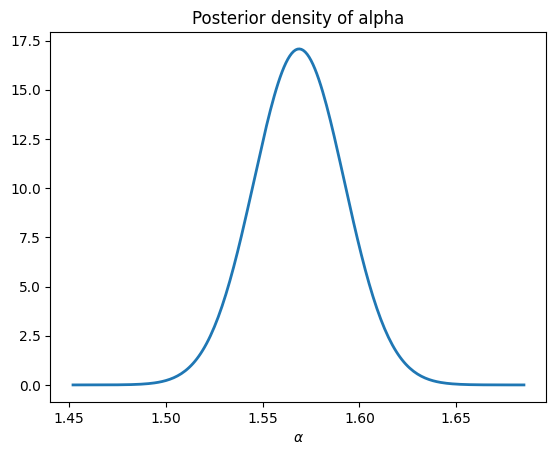

In [17]:
plt.figure()
x_plot = np.arange((np.mean(best_alpha)-5*np.std(best_alpha)), (np.mean(best_alpha)+5*np.std(best_alpha)), 0.001)
y_plot = ss.norm.pdf(x_plot, np.mean(best_alpha), np.std(best_alpha))
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

Text(0.5, 1.0, 'Posterior density of beta')

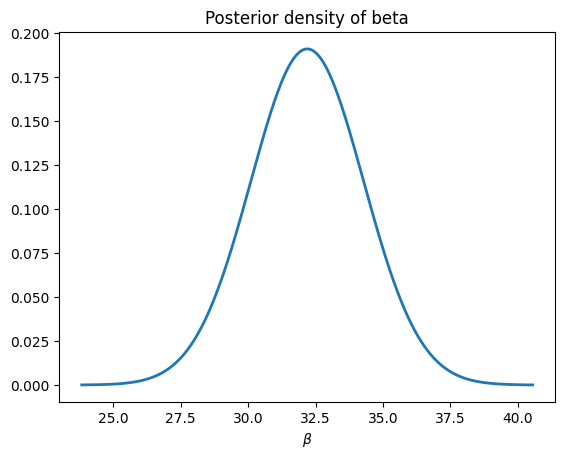

In [18]:
plt.figure()
x_plot = np.arange((np.mean(best_beta)-4*np.std(best_beta)), (np.mean(best_beta)+4*np.std(best_beta)), 0.001)
y_plot = ss.norm.pdf(x_plot, np.mean(best_beta), np.std(best_beta))
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

Text(0.5, 1.0, 'Posterior density of gamma')

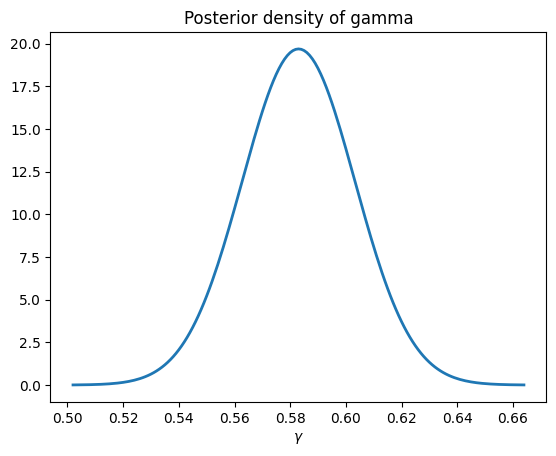

In [19]:
plt.figure()
x_plot = np.arange((np.mean(best_gamma)-4*np.std(best_gamma)), (np.mean(best_gamma)+4*np.std(best_gamma)), 0.001)
y_plot = ss.norm.pdf(x_plot, np.mean(best_gamma), np.std(best_gamma))
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')